In [64]:
'''
This script takes in data, calculates each persons reaction time, movement time, and timing mean and sd.
Then it plugs that in to the numerical simulations and runs it 

Then I graph the actual data with the optimal simulated data together to compare
'''

'\nThis script takes in data, calculates each persons reaction time, movement time, and timing mean and sd.\nThen it plugs that in to the numerical simulations and runs it \n\nThen I graph the actual data with the optimal simulated data together to compare\n'

In [65]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random
import numba as nb
from numba import njit

In [66]:
# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Pilot_v3')
PATH = os.getcwd()
save_path = '\\Figures\\'
if not os.path.exists(PATH+save_path):
        os.makedirs(PATH+save_path)

with open(PATH+"\\Analysis_Pull_List.txt","r") as pull_file:
    analysis_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt","r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()  
# SPECIFIC TO EXPERIMENT   
reaction_trials = 50    
timing_trials = 50
num_trials = 100 #number of trials in each block 
num_blocks = 6
tot_trials = num_trials*num_blocks
data_columns = len(fields_pull)
trial_time = 1500
num_subjects = len(analysis_pull_list)
wheel = dv.ColorWheel()

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

In [67]:
#%% Plot properties
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 

tp3_title = "1000,50"
tp4_title = "1000,150"
tp5_title = '1100,50'
tp6_title = "1100,150"
tp7_title = "1200,50"
tp8_title = '1200,150'
tp9_title = '1300,100'
tp10_title = '1300,200'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]

box_color1 = wheel.dark_blue
box_color2 = wheel.dark_red
box_color3 = '0.4'
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'
dot_color = 'black'   

### Functions

In [68]:
def update_params(label_color):
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              'figure.facecolor': 'black',
              'axes.facecolor' : 'black'
              }
    plt.rcParams.update(params)

In [69]:
def jitter(arr, data):
    if data.ndim >1:
        arr = np.tile(arr,(np.shape(data)[0],1))
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    else:
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    return arr

In [70]:
#%% Double Box plot with dots Function
def double_boxplot(X_locations, Y_locations, data1,data2, xlab, ylab, title, savename, save = False):
    if save:
        label_color = 'w'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    else:
        label_color = 'black'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    plt.figure(dpi = 125, figsize = (8,4))
    box_widths = 0.3
    X_locations = X_locations
    Y_locations = Y_locations
    ax = plt.subplot()
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    total = np.concatenate((data1, data2))
    ax.plot(jitter(X_locations+box_widths/2,np.shape(data1)).T, data1.T,color = '0.3', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    ax.plot(jitter(X_locations-box_widths/2, np.shape(data2)).T, data2.T,color = '0.3', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    #bplot two  #block number, dyad, right/left
    ax.boxplot(data1, positions=X_locations+box_widths/2, patch_artist=True, boxprops = two_props, whiskerprops = two_whisk, 
                capprops = two_cap, medianprops = two_median, showfliers=False, widths = box_widths)
    #bplot three
    ax.boxplot(data2, positions = X_locations-box_widths/2, patch_artist=True, boxprops = three_props, whiskerprops = three_whisk,
                capprops = three_cap, medianprops=three_median, showfliers = False, widths = box_widths)
    ax.set_xticks(X_locations)
    ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(Y_locations)
    ax.set_yticklabels(Y_locations) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    
    labels = ["Indecisions", "Incorrect Decisions"]
    colors = [wheel.dark_blue, wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors, fontsize = 10)
    if save:
        plt.savefig(PATH+save_path+savename, dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

In [71]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None):
    og_xlocs = xlocs
    box_xlocs = xlocs
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*4
        xlocs = xlocs + shift_direction*box_widths*4
        if shift_direction == 1:
            props = [three_props,three_whisk,three_cap,three_median]
        else:
            props = [two_props,two_whisk,two_cap,two_median]

    filtered_data = data
    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    #ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.dark_blue,wheel.dark_red]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 10)


In [72]:
def combine_sd(n1,n2,avg1,avg2,sd1,sd2):
    ans = np.sqrt((((n1-1)*sd1**2 + (n2-1)*sd2**2)/(n1+n2-1)) + ((n1*n2*(avg1-avg2)**2)/((n1+n2)*(n1+n2-1))))
    return ans

In [73]:
def combined_sd(n1,n2,avg1,avg2,sd1,sd2):
    avg = (n1*avg1 + n2*avg2)/(n1+n2)
    ans = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2 + n1(avg1-avg)**2 + n2*(avg2-avg)**2))

In [74]:
def combine_sd1(n1,n2,sd1,sd2):
    ans = np.sqrt(sd1**2/n1 + sd2**2/n2)
    return ans

### Pickle

In [75]:
player_wins = np.zeros((num_subjects, num_blocks))
player_indecisions = np.zeros((num_subjects, num_blocks))
perc_player_wins = np.zeros((num_subjects, num_blocks))
perc_player_wins_first_half = np.zeros((num_subjects, num_blocks))
perc_player_wins_second_half = np.zeros((num_subjects, num_blocks))
perc_player_wins_cut_off = np.zeros((num_subjects, num_blocks))
perc_player_indecisions = np.zeros((num_subjects, num_blocks))
perc_player_indecisions_first_half = np.zeros((num_subjects, num_blocks))
perc_player_indecisions_second_half = np.zeros((num_subjects, num_blocks))
perc_player_indecisions_cut_off = np.zeros((num_subjects, num_blocks))
trial_table = np.empty((num_subjects, tot_trials, 4), int)
player_reach_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
player_decision_array = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
reaction_time = np.zeros([num_subjects,reaction_trials])*np.nan 
reaction_movement_time = np.zeros([num_subjects,reaction_trials])*np.nan 
rt_trial_start = np.zeros((num_subjects,reaction_trials))*np.nan 
timing_reach_time = np.zeros([num_subjects,reaction_trials])*np.nan 
hand_pos_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, 4))*np.nan
agent_decision_time = np.zeros((num_subjects,num_blocks,num_trials))
agent_target_selection = np.zeros((num_subjects,num_blocks,num_trials))
player_incorrect_decisions = np.zeros((num_subjects,num_blocks))
perc_player_incorrect_decisions = np.zeros((num_subjects,num_blocks))
perc_player_incorrect_decisions_first_half = np.zeros((num_subjects, num_blocks))
perc_player_incorrect_decisions_second_half = np.zeros((num_subjects, num_blocks))
perc_player_incorrect_decisions_cut_off = np.zeros((num_subjects, num_blocks))
player_decision_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
for i in range(num_subjects):
    subname = analysis_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_player_indecisions.pkl', 'rb'))
    player_wins[i,:] = pickle.load(open(data_path + f'{subname}_player_wins.pkl', 'rb'))
    perc_player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions.pkl', 'rb'))
    perc_player_indecisions_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_first_half.pkl', 'rb'))
    perc_player_indecisions_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_second_half.pkl', 'rb'))
    perc_player_indecisions_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_cut_off.pkl', 'rb'))
    
    perc_player_wins[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins.pkl', 'rb'))
    perc_player_wins_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_first_half.pkl', 'rb'))
    perc_player_wins_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_second_half.pkl', 'rb'))
    perc_player_wins_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_cut_off.pkl', 'rb'))
    
    perc_player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions.pkl', 'rb'))
    perc_player_incorrect_decisions_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_first_half.pkl', 'rb'))
    perc_player_incorrect_decisions_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_second_half.pkl', 'rb'))
    perc_player_incorrect_decisions_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_cut_off.pkl', 'rb'))
    #trial_table[i,:,:] = pickle.load(open(data_path + f'{subname}_trial_table.pkl', 'rb'))
    player_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_reach_time.pkl', 'rb'))
    hand_pos_data[i,:,:,:,:] = pickle.load(open(data_path+f'{subname}_hand_pos_data.pkl', 'rb'))
    reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_time.pkl', 'rb'))
    reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_movement_time.pkl', 'rb'))
    rt_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_rt_trial_start.pkl', 'rb'))
    agent_decision_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_decision_time.pkl', 'rb'))
    agent_target_selection[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_target_selection.pkl', 'rb'))
    player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_player_incorrect_decisions.pkl', 'rb'))
    player_decision_time[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_time.pkl', 'rb'))
    player_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_array.pkl', 'rb'))
    timing_reach_time[i,:] = pickle.load(open(data_path + f'{subname}_timing_reach_time.pkl', 'rb'))
agent_reach_time = agent_decision_time+150

### Calculations

Reaction and Reaction Movement Time

In [76]:
#%% Calculate RT means and sds
reaction_time_mean = np.zeros(num_subjects)
reaction_time_sd = np.zeros(num_subjects)
reaction_movement_time_mean = np.zeros(num_subjects)
reaction_movement_time_sd = np.zeros(num_subjects)
movement_time_mean = np.zeros(num_subjects)
movement_time_sd = np.zeros(num_subjects)
movement_time = reaction_movement_time - reaction_time
timing_reach_time_mean = np.nanmean(timing_reach_time, axis=1)
timing_reach_time_sd = np.nanstd(timing_reach_time, axis =1)

# Reaction time
for i in range(num_subjects):
    reaction_time_mean[i] = np.nanmean(reaction_time[i,10:])
    reaction_time_sd[i] = np.nanstd(reaction_time[i,10:])
    reaction_movement_time_mean[i] = np.nanmean(reaction_movement_time[i,10:])
    reaction_movement_time_sd[i] = np.nanstd(reaction_movement_time[i,10:])
    movement_time_mean[i] = np.nanmean(movement_time[i,10:])
    movement_time_sd[i] = np.nanstd(movement_time[i,10:])


Experiment reach and decision times

In [77]:
# Actual trials
agent_mean_reach_time = np.nanmean(agent_reach_time,axis = 2)
agent_sd_reach_time = np.nanstd(agent_reach_time,axis = 2)
agent_mean_decision_time = np.nanmean(agent_decision_time, axis =2)
agent_sd_decision_time = np.nanstd(agent_decision_time, axis =2)
player_mean_reach_time = np.nanmean(player_reach_time,axis=2)
player_sd_reach_time = np.nanstd(player_reach_time,axis=2)
player_mean_decision_time = np.nanmean(player_decision_time,axis=2)
player_sd_decision_time = np.nanstd(agent_reach_time,axis = 2)

Reach Times on Indecisions

In [78]:
#%% Find agent reach times for player indecisions
agent_decision_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_left_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_left_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
indecision_index = np.argwhere(player_reach_time>1500)

c=0
for i,j,k in indecision_index:
    agent_decision_time_on_indecisions[i,j,k] = agent_decision_time[i,j,k]
    player_reach_time_on_indecisions[i,j,k] = player_reach_time[i,j,k]
    player_left_time_on_indecisions[i,j,k] = player_decision_time[i,j,k]
    c+=1
for i in range(num_subjects):
    for j in range(num_blocks):
        agent_mean_reach_time_on_indecisions[i,j] = np.nanmean(agent_decision_time_on_indecisions[i,j,:])
        player_mean_reach_time_on_indecisions[i,j] = np.nanmean(player_reach_time_on_indecisions[i,j,:])
        player_mean_left_time_on_indecisions[i,j] = np.nanmean(player_left_time_on_indecisions[i,j,:])



Gamble and reaction calculations

In [79]:
# Go through gamble reach times and then wins, indecisions, losses separately for reaction and gambles
#%% Average agent mean reach time on gamb

gamble_left_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_reach_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_reach_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_decision_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_index = np.argwhere(abs(agent_decision_time-player_decision_time)<REACTION_TIME)
for i,j,k in gamble_index:
    gamble_left_target_time[i,j,k] = player_decision_time[i,j,k]
    gamble_reach_target_time[i,j,k] = player_reach_time[i,j,k]
    agent_reach_time_gambles[i,j,k] = agent_reach_time[i,j,k]
    agent_decision_time_gambles[i,j,k] = agent_decision_time[i,j,k]

#%% Count wins where they gambled, wins where they reacted, losses when they gambled, losses when they reacted, and indecisions
## 200 is probably too small for two choice reaction 
gamble_index = np.argwhere(player_decision_time-agent_decision_time<REACTION_TIME)
reaction_index = np.argwhere((player_decision_time-agent_decision_time>=REACTION_TIME))
did_not_leave_start_index = np.argwhere((np.isnan(player_decision_time))) # This indiddex is for if they left the start too early, or didn't leave at all

#left_out = np.argwhere()
gamble_wins = np.zeros((num_subjects, num_blocks))
gamble_indecisions = np.zeros((num_subjects, num_blocks))
gamble_losses = np.zeros((num_subjects, num_blocks))
reaction_wins = np.zeros((num_subjects, num_blocks))
reaction_indecisions = np.zeros((num_subjects, num_blocks))
reaction_losses = np.zeros((num_subjects, num_blocks))
for i,j,k in gamble_index:
    if player_decision_array[i,j,k] == 1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        gamble_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        gamble_losses[i,j] += 1
    else:
        print('none')
    
  
for i,j,k in reaction_index:
    if player_decision_array[i,j,k] ==  1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        reaction_losses[i,j] += 1
    else:
        print("none triggerd")
for i,j,k in did_not_leave_start_index:
    if player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j]+=1 # If they ended up not mkaing it, it was likely due to reaction indecision
    #lif player_decision_array[i,j,k]*agent_target_selection[i,j,k]>0:
       
perc_gamble_wins = gamble_wins/num_trials*100
perc_gamble_losses = gamble_indecisions/num_trials*100
perc_gamble_indecisions = gamble_losses/num_trials*100
perc_reaction_wins = reaction_wins/num_trials*100
perc_reaction_losses = reaction_losses/num_trials*100
perc_reaction_indecisions = reaction_indecisions/num_trials*100


In [80]:
# Calculate the average reach time for each subject when they gamble for each condition 
gamble_index = np.argwhere(player_decision_time-agent_decision_time<REACTION_TIME)
reaction_index = np.argwhere((player_decision_time-agent_decision_time>=REACTION_TIME))
did_not_leave_start_index = np.argwhere((np.isnan(player_decision_time)))
gamble_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
reaction_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
for i,j,k in gamble_index:
    gamble_decision_times[i,j,k] = player_decision_time[i,j,k]
for i,j,k in reaction_index:
    reaction_decision_times[i,j,k] = player_decision_time[i,j,k]
    
# get means
gamble_decision_time_means = np.nanmean(gamble_decision_times, axis =2 )
reaction_decision_time_means = np.nanmean(reaction_decision_times, axis =2 )

C:\Users\SETHSU~1\AppData\Local\Temp/ipykernel_10568/1678591353.py:14: RuntimeWarning: Mean of empty slice
  reaction_decision_time_means = np.nanmean(reaction_decision_times, axis =2 )


Wins when both decide

In [81]:
# Get agent decision array
agent_decision_array = np.zeros((num_subjects,num_blocks,num_trials))
player_both_reached_wins = np.zeros((num_subjects, num_blocks))
perc_player_both_reached_wins = np.zeros((num_subjects, num_blocks))
agent_both_reached_wins = np.zeros((num_subjects, num_blocks))
for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_reach_time[i,j,k]>1500:
                agent_decision_array[i,j,k] = 0
            else:
                agent_decision_array[i,j,k] = agent_target_selection[i,j,k]
# Get wins when both decide
both_decide_index = np.argwhere(np.logical_and(player_decision_array!=0,agent_decision_array!=0))

for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_decision_array[i,j,k]*player_decision_array[i,j,k] == 1:
                player_both_reached_wins[i,j]+=1
            if agent_decision_array[i,j,k]*player_decision_array[i,j,k] == -1:
                agent_both_reached_wins[i,j]+=1
        x = np.count_nonzero(player_decision_array[i,j,:]!=0)
        y = np.count_nonzero(agent_decision_array[i,j,:]!=0)
        if x!= 0 and y!= 0:
            total = np.count_nonzero(np.logical_and(player_decision_array[i,j,:]!=0,agent_decision_array[i,j,:]!=0))
            perc_player_both_reached_wins[i,j] = (player_both_reached_wins[i,j]/total)*100



### Simulation Functions

In [82]:
#%% Simulation Function Only P1 Sensory Feedback
@njit 
def Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME,NUM_TRIALS,REACTION_TIME,MOVEMENT_TIME, target_reach_means_p1, target_reach_means_p2,
                  p1_reach_time, p2_reach_time, p1_decision_time, p2_decision_time):
    # Initialize what I want to return
    p1_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_indecision = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_indecision = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    neither_decision = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_decision_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    p2_decision_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS))
    p1_both_decided_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    p2_both_decided_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS))
    
    p1_reaction_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_gamble_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_gamble_losses = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    c = -1 #decision time iterator
    
        # Simulation -------------------------------------------------------------
    for dt_p1 in (target_reach_means_p1):
        c=c+1
        z=-1
        for dt_p2 in target_reach_means_p2:
            z=z+1
            for i in range(NUM_TRIALS): # can probably speed this up by doing the norm.rvs for the number of trials instead of running through a for loop, but not sure how to do the if statements then 
                
                #print(p1_reach_time[c,z,i],p2_reach_time[c,z,i])
                
                # Using sensory evidence ------------------------------------------
                # if player 1 is deciding after player 2 and player 2 has decided 
                # at least 200ms before 1500, then 1 can immediately win 
                
                if ((p1_decision_time[c,z,i] - p2_decision_time[c,z,i] >= REACTION_TIME) and (p2_decision_time[c,z,i] + REACTION_TIME + MOVEMENT_TIME < TRIAL_TIME)): # EVEN if p1 is over the trial time, if they can react in time to p2 then this gets triggered
                    p1_wins[c,z] += 1
                    p1_reaction_wins[c,z] +=1
                    p1_decision_time[c,z,i] = p2_decision_time[c,z,i] + REACTION_TIME # change decision time to reaction time after opponent
                    p1_reach_time[c,z,i] = p1_decision_time[c,z,i] + MOVEMENT_TIME 
                    p1_decision_array[c,z,i] = 1
                    p2_decision_array[c,z,i] = -1
                    p1_both_decided_array[c,z,i] = 1
                    p2_both_decided_array[c,z,i] = -1
                    if p1_reach_time[c,z,i]>TRIAL_TIME:
                        print('ERROR')
                    # Know that p2 didn't make an indecision because 1500-p2_dt >= 200 
                
                # if (p2_reach_time[c,z,i] >= p1_reach_time[c,z,i] +REACTION_TIME and 
                #       TRIAL_TIME - p1_reach_time[c,z,i] >=REACTION_TIME):
                #     p2_wins[c,z] += 1
                #     p2_reach_time[c,z,i] = p1_reach_time[c,z,i] +REACTION_TIME # change decision time to 200ms after opponent
                #     p1_decision_array[c,z,i] = -1
                #     p2_decision_array[c,z,i] = 1
                #     p1_both_decided_array[c,z,i] = -1
                #     p2_both_decided_array[c,z,i] = 1
                #-----------------------------------------------------------------
                # ------ No sensory evidence could be used------------------------
                
                # Both made it, random winner
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and
                      p2_reach_time[c,z,i]<TRIAL_TIME): 
                    rand = random.random()
                    if rand>=0.5:
                        p1_wins[c,z] += 1
                        p1_gamble_wins[c,z]+=1
                        p1_decision_array[c,z,i] = 1
                        p2_decision_array[c,z,i] = -1
                        p1_both_decided_array[c,z,i] = 1
                        p2_both_decided_array[c,z,i] = -1
                    else:
                        p2_wins[c,z] += 1    
                        p1_gamble_losses[c,z] += 1
                        p1_decision_array[c,z,i] = -1
                        p2_decision_array[c,z,i] = 1     
                        p1_both_decided_array[c,z,i] = -1
                        p2_both_decided_array[c,z,i] = 1                                                                                      
                # P1 didn't make it
                elif (p1_reach_time[c,z,i]>= TRIAL_TIME and
                      p2_reach_time[c,z,i]<TRIAL_TIME):
                    p2_wins[c,z] += 1
                    p1_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    p2_decision_array[c,z,i] = 1
                    p1_both_decided_array[c,z,i] = 0
                    p2_both_decided_array[c,z,i] = 1
                # P2 didn't make it
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and 
                      p2_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_wins[c,z] += 1
                    p1_gamble_wins[c,z] += 1
                    p2_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 1
                    p2_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 1
                    p2_both_decided_array[c,z,i] = 0
                # Both didn't make it 
                elif (p1_reach_time[c,z,i]>=TRIAL_TIME and 
                      p2_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_indecision[c,z] += 1
                    p2_indecision[c,z] += 1
                    neither_decision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    p2_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 0
                    p2_both_decided_array[c,z,i] = 0
                else:
                    print("ERROR NO IF STATEMENT TRIGGERED")     
    return p1_wins, p2_wins, p1_indecision, p2_indecision, p1_reach_time, p2_reach_time, p1_decision_time,p2_decision_time, \
        p1_decision_array, p2_decision_array, p1_both_decided_array, p2_both_decided_array         

In [83]:
#%% Calculate both decided wins
@njit
def calc_both_decide_wins(NUM_TRIALS, target_reach_means_p1,target_reach_means_p2,
                          p1_decision_array,
                          p2_decision_array, 
                          p1_both_decided_array, 
                          p2_both_decided_array):
    p1_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
       
    # p1_both_decided_array = p1_decision_array #decision array
    # p2_both_decided_array = p2_decision_array     
    p1_indecision_index = np.argwhere(p1_decision_array == 0)
    p2_indecision_index = np.argwhere(p2_decision_array == 0)
      # Create arrays for when both decide 
      #Replace all 0's (indecisions) with nans
    for i,j,k in p1_indecision_index:
        p1_both_decided_array[i,j,k] = np.nan
        p2_both_decided_array[i,j,k] = np.nan
    for i,j,k in p2_indecision_index:
       p1_both_decided_array[i,j,k] = np.nan
       p2_both_decided_array[i,j,k] = np.nan
    
    # Count wins for each when both decide
    for i in range(len(target_reach_means_p1)):
        for j in range(len(target_reach_means_p2)):
            for k in range(NUM_TRIALS):
                if p1_both_decided_array[i,j,k]==1 and p2_both_decided_array[i,j,k] == -1:
                    p1_both_decided_wins[i,j] += 1
                    # if np.isnan(p1_both_decided_array[i]):
                    #     print('error')
                    #print(f"Right wins on correct choice: {decision_array_R[i,j,k]}, {decision_array_L[i,j,k]}")
                # Prey won for correct choice
                elif p2_both_decided_array[i,j,k]==1 and p1_both_decided_array[i,j,k] == -1:
                    p2_both_decided_wins[i,j] += 1
                    
            x = np.count_nonzero(~np.isnan(p1_both_decided_array[i,j,:]))
            y = np.count_nonzero(~np.isnan(p2_both_decided_array[i,j,:]))
            if x != 0 and y != 0:
                total = np.count_nonzero(np.logical_and(p1_decision_array[i,j,:]!=0,p2_decision_array[i,j,:]!=0))
                p1_perc_both_decided_wins[i,j] = (p1_both_decided_wins[i,j] / total)*100
                p2_perc_both_decided_wins[i,j] = (p2_both_decided_wins[i,j] / total)*100
            else:
                p1_perc_both_decided_wins[i,j] = np.nan
                p2_perc_both_decided_wins[i,j] = np.nan
        
    return p1_perc_both_decided_wins, p2_perc_both_decided_wins


### Run Simulation with subject data 


In [84]:
print(timing_reach_time_sd)
print(reaction_movement_time_sd)

[65.45952646 77.8018226  91.22691708 69.37429207 68.64093239]
[ 40.74002178  74.39959677  24.7074761   34.46403016 109.02068611]


Reaction Time Mean = 300.0
Timing_reach_time_mean = 1478.7755102040817
Overall Uncertainty = 106.19954824420685
[1218.39 1221.6  1331.07]
0.0 99.94 1149.8893908015248
0.54 99.07000000000001 1250.5455132113555
24.39 71.8 1373.540067282573


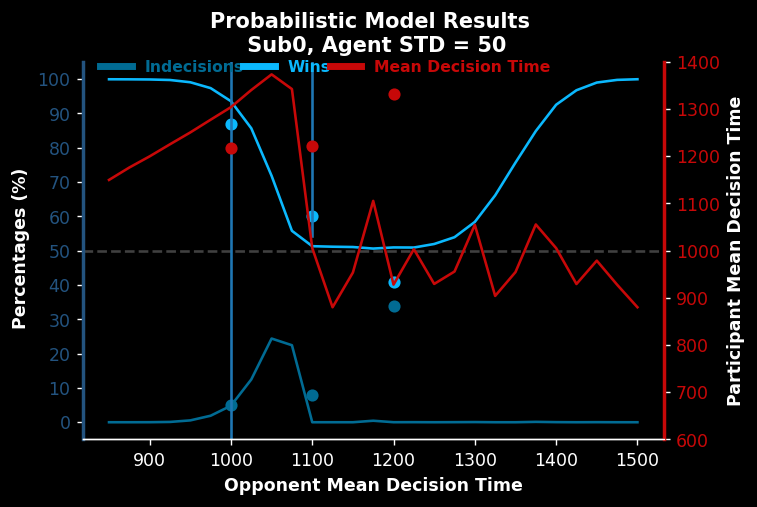

3.83 93.76 1142.5453940732043
14.44 81.41000000000001 1248.96722472105
9.59 65.02 1251.992140736016


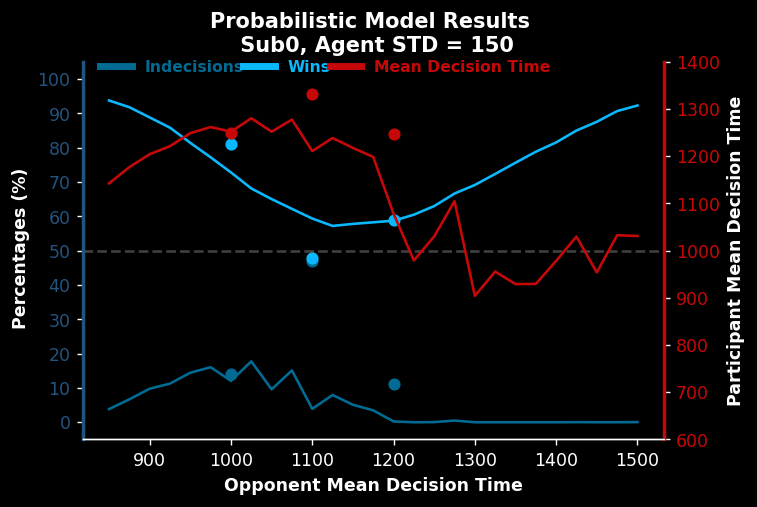

Reaction Time Mean = 306.125
Timing_reach_time_mean = 1436.42
Overall Uncertainty = 152.20141937386003
[1314.78 1237.93 1154.94]
0.03 98.94 1154.4894514755554
4.25 92.10000000000001 1257.6067142147429
0.42 50.839999999999996 961.9618707427379


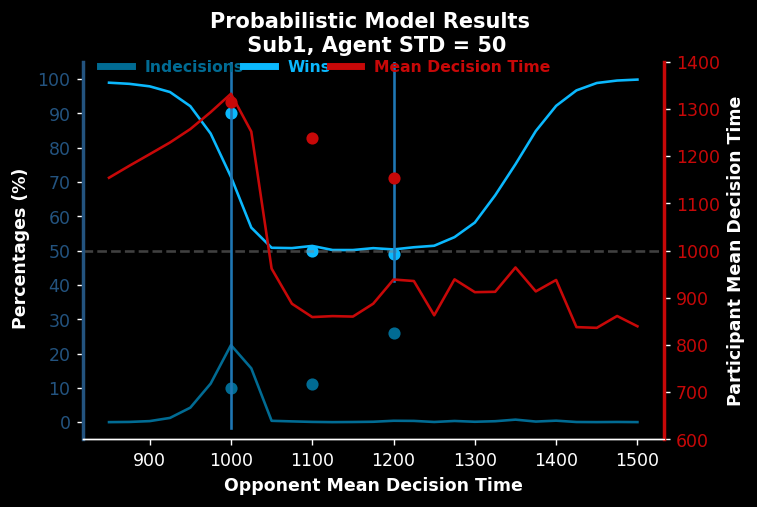

9.15 88.75 1160.8882578350585
21.54 72.08 1251.9984289716406
8.76 56.31 1162.6308342696768


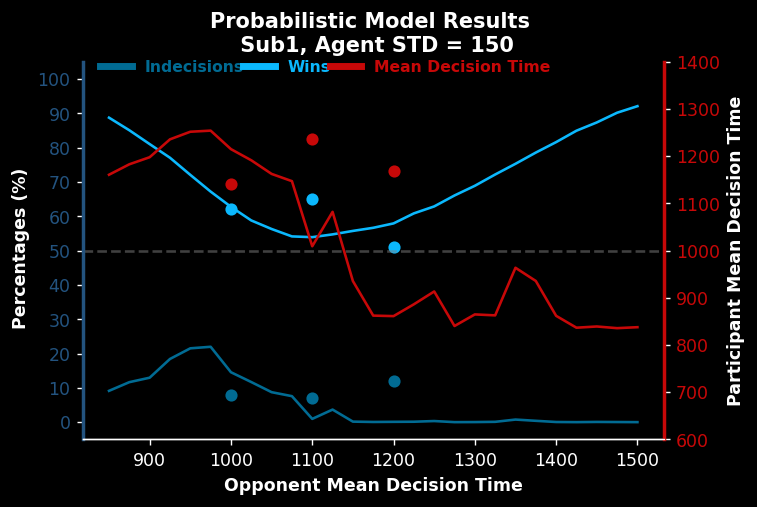

Reaction Time Mean = 282.675
Timing_reach_time_mean = 1487.36
Overall Uncertainty = 115.93439317573552
[1204.97979798 1148.79        914.24      ]
0.01 99.82 1132.5980555375886
4.130000000000001 94.37 1237.6012094665978
0.13999999999999999 51.06 991.3242482521739


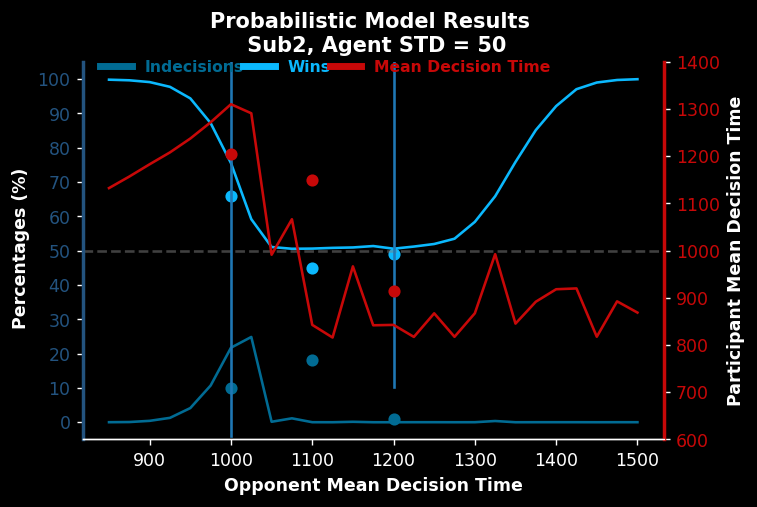

7.140000000000001 89.36 1126.6569304183506
16.259999999999998 73.48 1207.0255412892404
10.23 57.79 1187.9464528471467


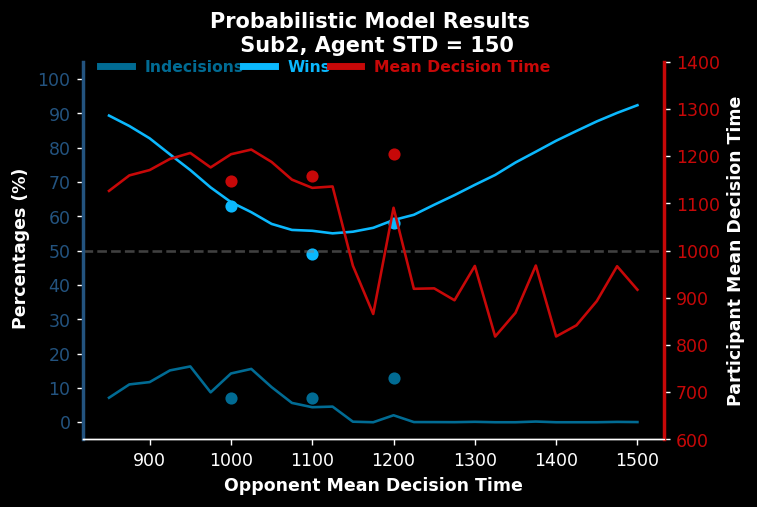

Reaction Time Mean = 300.15
Timing_reach_time_mean = 1457.74
Overall Uncertainty = 103.83832223035495
[1104.91 1227.07 1209.91]
0.0 99.95 1149.450389014369
4.02 95.14 1254.7213303409778
1.1400000000000001 51.12 1109.769621247734


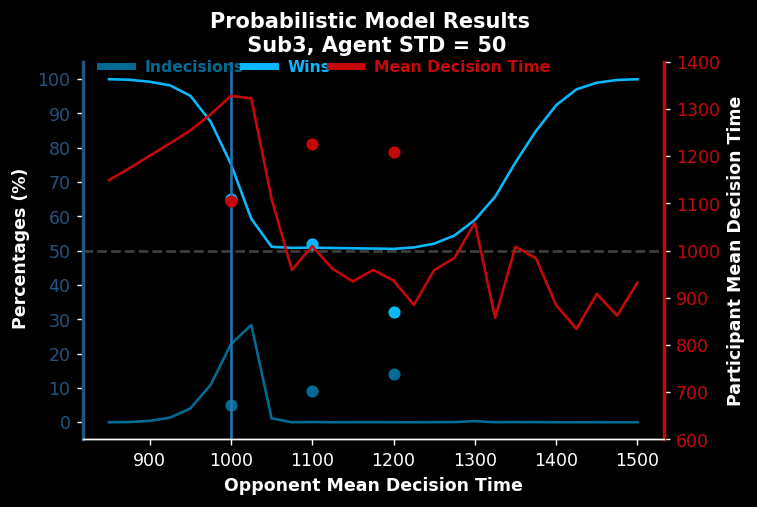

7.180000000000001 89.3 1145.3066568626882
16.91 73.63 1226.195632837643
8.72 58.01 1205.4253034900723


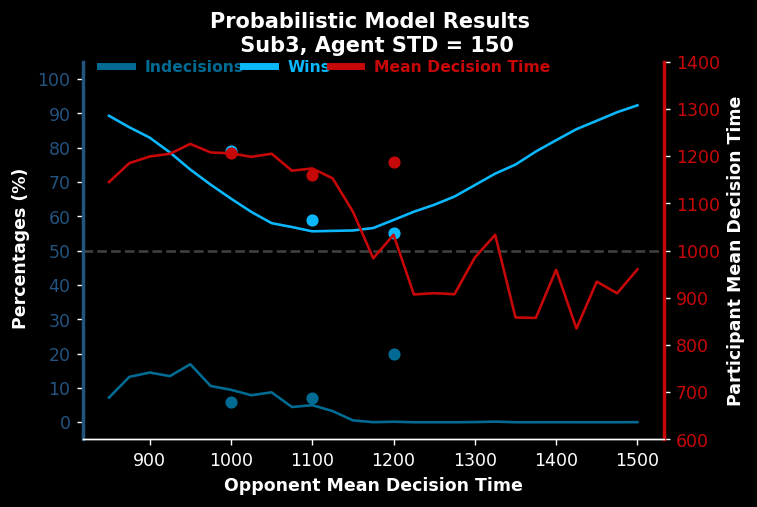

Reaction Time Mean = 270.575
Timing_reach_time_mean = 1468.32
Overall Uncertainty = 177.66161850508055
[1273.07 1369.87 1394.46]
0.0 99.35000000000001 1119.7766114818808
0.03 97.65 1217.7064815473086
8.34 85.82 1325.8094181234503


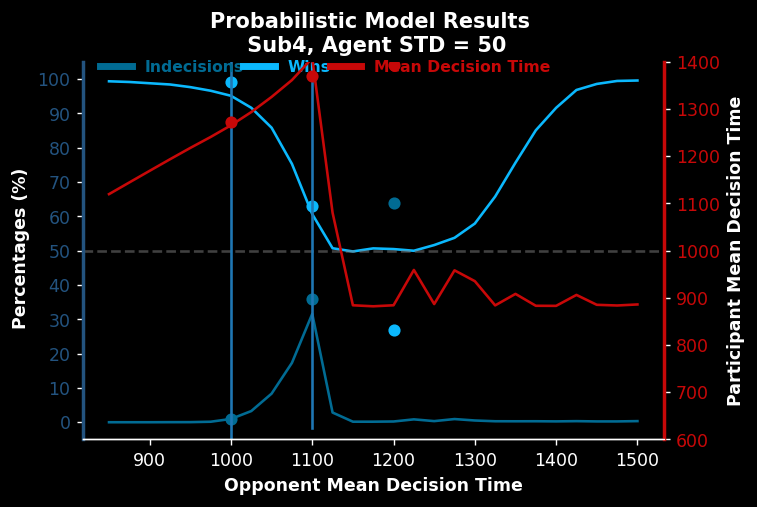

3.34 95.06 1122.612766422269
11.129999999999999 85.61 1227.4280685315027
21.9 67.95 1301.5122611076674


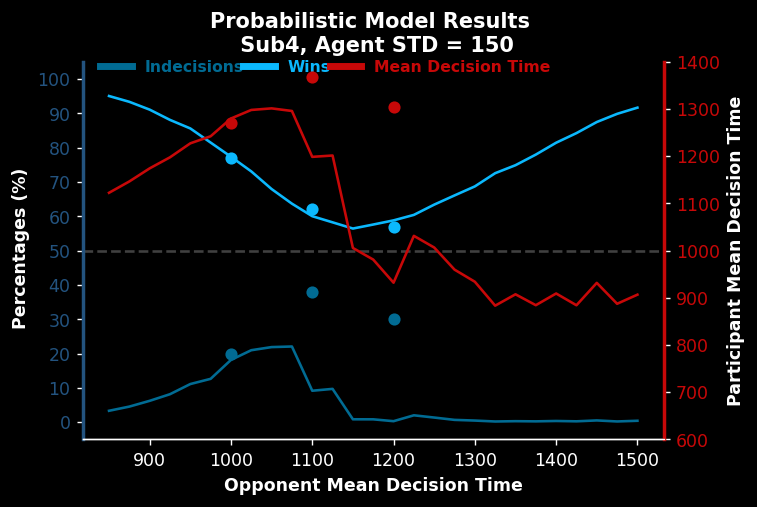

In [163]:
# Calculate std of player
subject_number = np.arange(0,num_subjects)
for sub_num in subject_number:
    p1_std = reaction_movement_time_sd[sub_num]+timing_reach_time_sd[sub_num]
    print(f"Reaction Time Mean = {reaction_time_mean[sub_num]}")
    print(f'Timing_reach_time_mean = {timing_reach_time_mean[sub_num]}')
    print(f'Overall Uncertainty = {p1_std}')
    p1_std = [p1_std]
    p2_std = [50,150]
    update_params('w')
    figs = [] # Empty list to store figures so I can change them around on the next cell
    a,b = -1,-1
    for sig1 in (p1_std):
        a+=1
        for sig2 in p2_std:
            b+=1
            #%% Constant Variables
            TRIAL_TIME = 1500
            NUM_TRIALS = 10000
            REACTION_TIME = reaction_time_mean[sub_num]
            MOVEMENT_TIME = movement_time_mean[sub_num]
            AGENT_MOVEMENT_TIME = 150
            #Start and end decision time for player 1
            interval = 25
            start_time1 = 1000
            end_time1 = 1650
            total_times1 = int((end_time1 - start_time1) / interval)+1
            target_reach_means_p1 = np.zeros(total_times1)
            # Start and end decision time for player 2
            start_time = 1000
            end_time = 1650
            total_times2 = int((end_time - start_time) / interval)+1
            target_reach_means_p2 = np.zeros(total_times2)
            # Creating AVERAGE decision time arrays
            # To be used in the norm.rvs
            for i in range(total_times1):
                target_reach_means_p1[i] = start_time1
                start_time1 = start_time1 + interval
            for i in range(total_times2):
                target_reach_means_p2[i] = start_time
                start_time = start_time + interval
            target_reach_means_p1 = target_reach_means_p1.astype(int)
            target_reach_means_p2 = target_reach_means_p2.astype(int)
            #Decision time storage arrays
            p1_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
            p2_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
            p1_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
            p2_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
            p1_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
            p2_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))

            #%% Run Simulation w/ SD = 100,100
            
            c=-1
            for dt_p1 in (target_reach_means_p1):
                c=c+1
                z=-1
                for dt_p2 in target_reach_means_p2:
                    z=z+1
                    # p1_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                    # p2_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p2, 100, size = NUM_TRIALS)
                    p1_reach_time[c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS)
                    p2_reach_time[c,z,:] = norm.rvs(dt_p2, sig2, size = NUM_TRIALS)
            p1_decision_time = p1_reach_time - MOVEMENT_TIME
            p2_decision_time = p2_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


            #make response time arrays
            # for dt_p1 in tqdm(target_reach_means_p1):
            #         c=c+1
            #         z=-1
            #         for dt_p2 in target_reach_means_p2:
            #             z=z+1

            #-----------------------------------------------------------------------------
            p1_wins, p2_wins, p1_indecision, p2_indecision, \
                p1_reach_time, p2_reach_time, p1_decision_time, p2_decision_time, p1_decision_array, p2_decision_array, \
                    p1_both_decided_array, p2_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, REACTION_TIME,MOVEMENT_TIME,
                                                                                                        target_reach_means_p1, target_reach_means_p2, 
                                                                                                        p1_reach_time, p2_reach_time,
                                                                                                        p1_decision_time,p2_decision_time)
            # Calculate both decided wins
            p1_perc_both_decided_wins, p2_perc_both_decided_wins = \
                calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_p2, p1_decision_array, p2_decision_array,  p1_both_decided_array,p2_both_decided_array)
            # Caluclate mean decision times
            
            #%% Find optimal control policy 
            # Find average of actual decision times
            p1_avg_dt = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
            p1_avg_dt_final = np.zeros(len(target_reach_means_p1))
            for i in range(len(target_reach_means_p1)):
                for j in range(len(target_reach_means_p2)):
                    p1_avg_dt[i,j] = np.mean(p1_decision_time[i,j,:])
            for i in range(len(target_reach_means_p1)):
                p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])  
                
            optimal_mean_decision_time = np.zeros(len(target_reach_means_p1))
            optimal_indecisions = np.zeros(len(target_reach_means_p1))
            optimal_wins = np.zeros(len(target_reach_means_p1))
            perc_optimal_both_decided_wins = np.zeros(len(target_reach_means_p1))
            for j in range(len(target_reach_means_p2)):
                max_win_index = np.argmax(p1_wins[:,j])
                optimal_mean_decision_time[j] = p1_avg_dt[max_win_index,j]
                optimal_indecisions[j] = p1_indecision[max_win_index,j]
                optimal_wins[j] = p1_wins[max_win_index,j]
                perc_optimal_both_decided_wins[j] = p1_perc_both_decided_wins[max_win_index,j]
            perc_optimal_wins = optimal_wins/NUM_TRIALS*100
            perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

            # #%% All on one, with vertical lines on the selected mean decision time
            # plt.figure(dpi=125)
            # ax = plt.subplot()
            # ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
            # ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
            # #ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
            # ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
            # # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
            # # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
            # ax.set_ylim(-5,105)
            # ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
            # ax.set_xlabel("Opponent Mean Decision Time")
            # ax.set_ylabel(' Percentages (%)')
            # ax.spines['left'].set_color(wheel.dark_blue)
            # ax.spines['left'].set_linewidth(2)
            # ax.spines['top'].set_visible(False)

            # ax2 = ax.twinx()
            # ax2.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,optimal_mean_decision_time,'-o', c=wheel.dark_red)
            # ax2.set_yticks(np.arange(400,1600,100))
            # ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
            # ax2.set_ylim(600,1400)
            # ax2.spines['right'].set_visible(True)
            # ax2.spines['right'].set_color(wheel.dark_red)
            # ax2.spines['right'].set_linewidth(2)
            # ax2.set_ylabel('Participant Mean Decision Time')
            # ax2.spines['left'].set_visible(False)
            # ax2.spines['top'].set_visible(False)
            # #ax.set_title(f'P1 SD = {sig1}, P2 SD = {sig2}')
            # ax.set_title('Probabilistic Model Results')
            # labels = ['Indecisions', 'Wins','Mean Decision Time']
            # colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
            # dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3)
            # #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{REACTION_TIME}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
            # plt.show()
            
            # Plot lines with the player means as points
            condition_times = [1000,1100,1200]
            if sig2 == 50:
                player_mean_decision_time1 = player_mean_decision_time[sub_num,::2] # This takes every other index, so only the 50 std ones
                perc_player_indecisions1 = perc_player_indecisions[sub_num,::2]
                perc_player_wins1 = perc_player_wins[sub_num,::2]
                print(player_mean_decision_time1)
        
            else:
                perc_player_indecisions1 = perc_player_indecisions[sub_num,1::2]
                perc_player_wins1 = perc_player_wins[sub_num,1::2]
                player_mean_decision_time1 = player_mean_decision_time[sub_num,1::2] # Same as above but starts at index of 1
                
            fig,ax = plt.subplots(dpi = 125)
            ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_indecisions, c = wheel.dark_blue2, label = 'Indecisions')
            ax.scatter(condition_times,perc_player_indecisions1, c = wheel.dark_blue2)    
            ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_wins, c = wheel.light_blue, label = 'Wins')
            ax.scatter(condition_times,perc_player_wins1, c = wheel.light_blue)
            x = condition_times
            ax.plot((condition_times,condition_times),  ([p for (p,q) in perc_optimal_indecisions,perc_player_indecisions1], [q for (p,q) in ]
            #ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
            ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
            # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
            # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
            ax.set_ylim(-5,105)
            ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
            ax.set_xlabel("Opponent Mean Decision Time")
            ax.set_ylabel(' Percentages (%)')
            ax.spines['left'].set_color(wheel.dark_blue)
            ax.spines['left'].set_linewidth(2)
            ax.spines['top'].set_visible(False)

            ax2 = ax.twinx()
            ax2.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,optimal_mean_decision_time, c=wheel.dark_red)
            ax2.scatter(condition_times, player_mean_decision_time1, c= wheel.dark_red)
            c=-1
            # for x in condition_times:
            #     c+=1
            #     index = np.argwhere(target_reach_means_p2 == x)
            #     index = index[0][0]
            #     print(perc_optimal_indecisions[index],perc_optimal_wins[index],optimal_mean_decision_time[index])
            #     ax.axvline(x,perc_optimal_indecisions[index],perc_player_indecisions1[c])
            #     ax.axvline(x,perc_optimal_wins[index],perc_player_wins1[c])
            #     ax2.axvline(x,optimal_mean_decision_time[index],player_mean_decision_time1[c])
                
            ax2.set_yticks(np.arange(400,1600,100))
            ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
            ax2.set_ylim(600,1400)
            ax2.spines['right'].set_visible(True)
            ax2.spines['right'].set_color(wheel.dark_red)
            ax2.spines['right'].set_linewidth(2)
            ax2.set_ylabel('Participant Mean Decision Time')
            ax2.spines['left'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            #ax.set_title(f'P1 SD = {sig1}, P2 SD = {sig2}')
            ax.set_title(f'Probabilistic Model Results \n Sub{sub_num}, Agent STD = {sig2}')
            labels = ['Indecisions', 'Wins','Mean Decision Time']
            colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
            dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3)
            #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{REACTION_TIME}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
            plt.show()
            figs.append(fig)
        
        
        #plot_list.append(ax)

In [159]:
perc_player_indecisions1

array([ 5.,  8., 34.])

### Plot Optimal lines with subject data

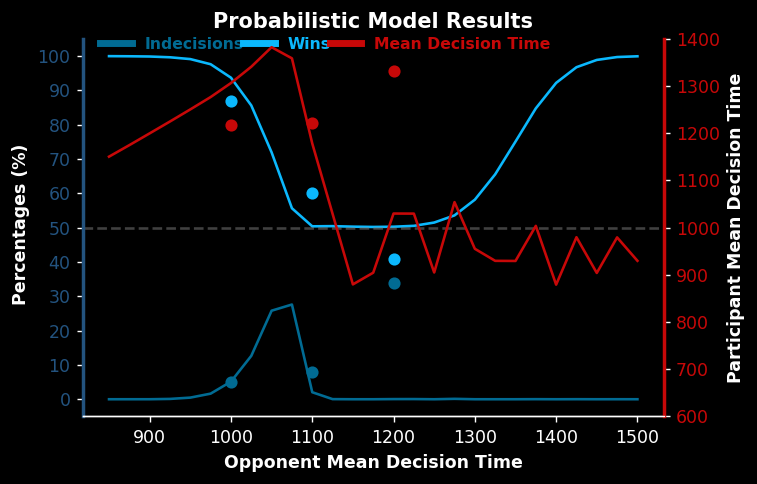

In [142]:
figs[0].gca().scatter(condition_times,[50,50,50])
figs[0]

In [86]:
np.sqrt(30**2/50 + 60**2/50)

9.486832980505138

In [101]:
a = [0,1,2,3,4,5,6]
print(a[::2])

[0, 2, 4, 6]
